In [1]:
import sys
import os

from glob import glob
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from dotenv import load_dotenv

from vap_sound.utils.evaluate_model import evaluate_model


load_dotenv()


# MODEL_PATH = os.environ.get("MODEL_PATH")
MODEL_PATH = "vap_model_2.pkl"
# LOG_MODEL_EVALUATION = os.environ.get("LOG_MODEL_EVALUATION")
LOG_MODEL_EVALUATION = "../logs/model_evaluation_2.log"

# LOG_MODEL_PREDICTION = os.environ.get("LOG_MODEL_PREDICTION")
LOG_MODEL_PREDICTION = "../logs/model_prediction_2.log"

In [ ]:
import pickle

# Function to save model as pickle file
def save_model_pickle(model, path):
    with open(path, "wb") as f:
        pickle.dump(model, f)
    print("Model saved successfully as pickle file!")

# Function to load model from pickle file
def load_model_pickle(path):
    with open(path, "rb") as f:
        model = pickle.load(f)
    model.eval()
    print("Model loaded successfully from pickle file!")
    return model

# Collate function to pad variable-length sequences
def collate_fn(batch):
    features, labels = zip(*batch)
    features_padded = pad_sequence(features, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=0)
    return features_padded, labels_padded

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn


####  DEFINE PARAMETERS ####

LSTM_HIDDEN_SIZE = 128
LSTM_LAYERS = 2

DROPOUT = 0.5


TRANSFORMER_HEAD_SIZE = 8
TRANSFORMER_NUM_LAYERS = 4
HIDDEN_DIM = 128


LEARNING_RATE = 0.001


NUM_EPOCHS = 10

class VAPModel(nn.Module):
    def __init__(self, 
                 input_dim=40, 
                 lstm_hidden_dim=128, 
                 num_heads=4,
                 transformer_layers=2, 
                 lstm_layers=2, 
                 output_dim=1):
        super(VAPModel, self).__init__()

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads),
            num_layers=transformer_layers
        )

        self.lstm = nn.LSTM(input_dim, lstm_hidden_dim, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_dim, output_dim)

    def forward(self, x):
        x = self.transformer(x)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return torch.sigmoid(x)



# Collating data for training  --> Input is Pandas DataFrame
class VAPDataset(Dataset):
    def __init__(self, data_df, seq_length=100):
        # if isinstance(csv_files, str):
        #     csv_files = [csv_files]
        
        self.seq_length = seq_length
        # self.data = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
        self.features = [torch.tensor(f) for f in data_df['features']]
        self.labels = [torch.tensor(l) for l in data_df['labels']]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        
        if feature.shape[0] > self.seq_length:
            feature = feature[-self.seq_length:]
            label = label[-self.seq_length:]
        else:
            pad_length = self.seq_length - feature.shape[0]
            feature = torch.cat([torch.zeros(pad_length, feature.shape[1]), feature], dim=0)
            label = torch.cat([torch.zeros(pad_length, label.shape[1]), label], dim=0)
        
        return feature, label
    

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

model1 = VAPModel()


# Training function
def train_model(training_data, batch_size=16, epochs=10, seq_length=100, learning_rate = LEARNING_RATE, model=model1):
    """
    Train the model using the provided training data.

    Args:
        model (nn.Module): The model to train.
        training_data (pd.DataFrame): DataFrame containing 'features' and 'labels' columns.
        batch_size (int): Batch size for training.
        epochs (int): Number of epochs to train.
        seq_length (int): Fixed sequence length for padding/truncation.
    """
    if os.path.exists(MODEL_PATH):
        model = load_model_pickle(path=MODEL_PATH)
    # Create dataset and dataloader
    train_dataset = VAPDataset(training_data, seq_length=seq_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0

        # Training phase
        for features, labels in train_loader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(features)  # Shape: (batch_size, seq_length, 1)

            # Ensure labels have the same shape as outputs
            if labels.dim() == 2:  # If labels are (batch_size, seq_length)
                labels = labels.unsqueeze(-1)  # Shape: (batch_size, seq_length, 1)
            elif labels.dim() == 3:  # If labels are already (batch_size, seq_length, 1)
                pass  # Do nothing
            else:
                raise ValueError(f"Unexpected labels shape: {labels.shape}")



            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation phase (using the same data for simplicity)
        model.eval()
        with torch.no_grad():
            for features, labels in train_loader:
                outputs = model(features)

                # Ensure labels have the same shape as outputs
                if labels.dim() == 2:  # If labels are (batch_size, seq_length)
                    labels = labels.unsqueeze(-1)  # Shape: (batch_size, seq_length, 1)
                elif labels.dim() == 3:  # If labels are already (batch_size, seq_length, 1)
                    pass  # Do nothing
                else:
                    raise ValueError(f"Unexpected labels shape: {labels.shape}")

                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Log training and validation loss
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(train_loader):.4f}")
    save_model_pickle(model, path=MODEL_PATH)
    print("Training complete!")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

model1 = VAPModel()


# Training function
def train_model(training_data, batch_size=16, epochs=10, seq_length=100, learning_rate = LEARNING_RATE, model=model1):
    """
    Train the model using the provided training data.

    Args:
        model (nn.Module): The model to train.
        training_data (pd.DataFrame): DataFrame containing 'features' and 'labels' columns.
        batch_size (int): Batch size for training.
        epochs (int): Number of epochs to train.
        seq_length (int): Fixed sequence length for padding/truncation.
    """
    if os.path.exists(MODEL_PATH):
        model = load_model_pickle(path=MODEL_PATH)
    # Create dataset and dataloader
    train_dataset = VAPDataset(training_data, seq_length=seq_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0

        # Training phase
        for features, labels in train_loader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(features)  # Shape: (batch_size, seq_length, 1)

            # Ensure labels have the same shape as outputs
            if labels.dim() == 2:  # If labels are (batch_size, seq_length)
                labels = labels.unsqueeze(-1)  # Shape: (batch_size, seq_length, 1)
            elif labels.dim() == 3:  # If labels are already (batch_size, seq_length, 1)
                pass  # Do nothing
            else:
                raise ValueError(f"Unexpected labels shape: {labels.shape}")



            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation phase (using the same data for simplicity)
        model.eval()
        with torch.no_grad():
            for features, labels in train_loader:
                outputs = model(features)

                # Ensure labels have the same shape as outputs
                if labels.dim() == 2:  # If labels are (batch_size, seq_length)
                    labels = labels.unsqueeze(-1)  # Shape: (batch_size, seq_length, 1)
                elif labels.dim() == 3:  # If labels are already (batch_size, seq_length, 1)
                    pass  # Do nothing
                else:
                    raise ValueError(f"Unexpected labels shape: {labels.shape}")

                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Log training and validation loss
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(train_loader):.4f}")
    save_model_pickle(model, path=MODEL_PATH)
    print("Training complete!")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [14]:
from glob import glob
import os
import pandas as pd

data_dir = "/Users/shanujha/Desktop/voice_activity_prediction/voice_data_mozilla/en/clips"
audio_files = glob(os.path.join(data_dir, "*.mp3"))


CSV_FILE_PATH = "/Users/shanujha/Desktop/voice_activity_prediction/logs/trained_mp3_files.csv"


data = {"file_paths": audio_files, "processed": [0 for i in range(len(audio_files))]}
file_df = pd.DataFrame(data)
# print(file_df.head())
# csv_df.to_csv(CSV_FILE_PATH, index=False)

# file_df = pd.read_csv(CSV_FILE_PATH)

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/vad-crdnn-libriparty' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/vad-crdnn-libriparty' if not cached
INFO:speechbrain.utils.fetching:Fetch model.ckpt: Fetching from HuggingFace Hub 'speechbrain/vad-crdnn-libriparty' if not cached
INFO:speechbrain.utils.fetching:Fetch mean_var_norm.ckpt: Fetching from HuggingFace Hub 'speechbrain/vad-crdnn-libriparty' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: model, mean_var_norm


Epoch 1/10, Train Loss: 0.6096, Val Loss: 0.5038
Epoch 2/10, Train Loss: 0.5790, Val Loss: 0.5297
Epoch 3/10, Train Loss: 0.4973, Val Loss: 0.4542
Epoch 4/10, Train Loss: 0.4771, Val Loss: 0.4460
Epoch 5/10, Train Loss: 0.4950, Val Loss: 0.4589
Epoch 6/10, Train Loss: 0.4640, Val Loss: 0.4709
Epoch 7/10, Train Loss: 0.4395, Val Loss: 0.4258
Epoch 8/10, Train Loss: 0.4227, Val Loss: 0.4134
Epoch 9/10, Train Loss: 0.4158, Val Loss: 0.3937
Epoch 10/10, Train Loss: 0.4157, Val Loss: 0.4020
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5918
Confusion Matrix:
[[17370    91]
 [12154   385]]


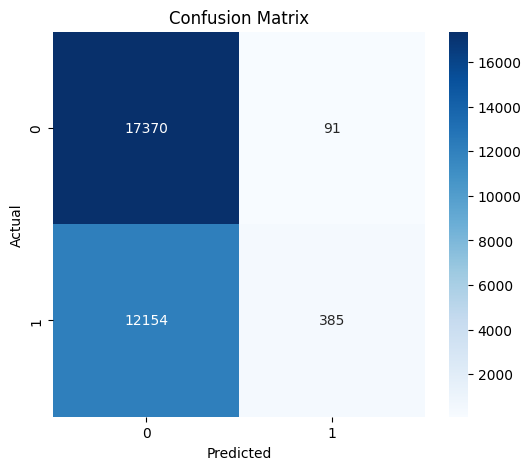

BATCH 1 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4278, Val Loss: 0.4159
Epoch 2/10, Train Loss: 0.4138, Val Loss: 0.4068
Epoch 3/10, Train Loss: 0.4083, Val Loss: 0.4246
Epoch 4/10, Train Loss: 0.4085, Val Loss: 0.3925
Epoch 5/10, Train Loss: 0.3991, Val Loss: 0.3829
Epoch 6/10, Train Loss: 0.3954, Val Loss: 0.3763
Epoch 7/10, Train Loss: 0.3933, Val Loss: 0.3630
Epoch 8/10, Train Loss: 0.3885, Val Loss: 0.3740
Epoch 9/10, Train Loss: 0.3884, Val Loss: 0.3752
Epoch 10/10, Train Loss: 0.3739, Val Loss: 0.3841
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.6039
Confusion Matrix:
[[17804    22]
 [11862   312]]


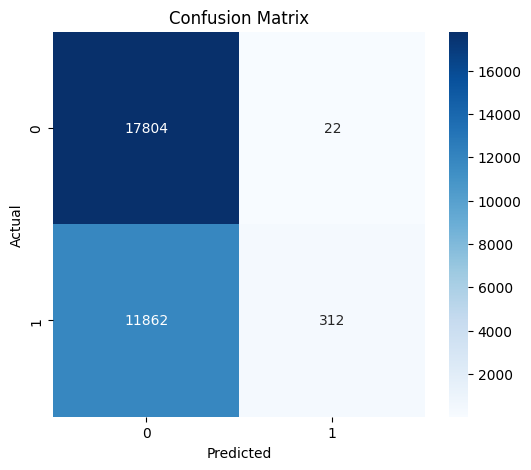

BATCH 2 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4602, Val Loss: 0.4296
Epoch 2/10, Train Loss: 0.4206, Val Loss: 0.4070
Epoch 3/10, Train Loss: 0.4161, Val Loss: 0.3999
Epoch 4/10, Train Loss: 0.4082, Val Loss: 0.3911
Epoch 5/10, Train Loss: 0.4024, Val Loss: 0.3918
Epoch 6/10, Train Loss: 0.3903, Val Loss: 0.3881
Epoch 7/10, Train Loss: 0.3931, Val Loss: 0.3805
Epoch 8/10, Train Loss: 0.3906, Val Loss: 0.3848
Epoch 9/10, Train Loss: 0.3952, Val Loss: 0.3887
Epoch 10/10, Train Loss: 0.3972, Val Loss: 0.3726
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5792
Confusion Matrix:
[[17024    11]
 [12612   353]]


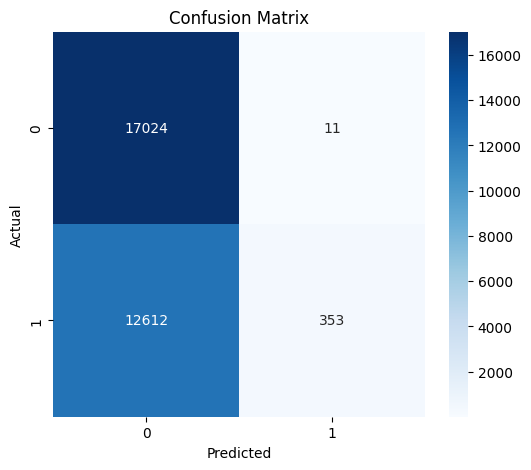

BATCH 3 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4059, Val Loss: 0.3788
Epoch 2/10, Train Loss: 0.3810, Val Loss: 0.3636
Epoch 3/10, Train Loss: 0.3729, Val Loss: 0.3761
Epoch 4/10, Train Loss: 0.3792, Val Loss: 0.3660
Epoch 5/10, Train Loss: 0.3610, Val Loss: 0.3531
Epoch 6/10, Train Loss: 0.3648, Val Loss: 0.3514
Epoch 7/10, Train Loss: 0.3662, Val Loss: 0.3542
Epoch 8/10, Train Loss: 0.3490, Val Loss: 0.3498
Epoch 9/10, Train Loss: 0.3737, Val Loss: 0.3701
Epoch 10/10, Train Loss: 0.3588, Val Loss: 0.3551
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5825
Confusion Matrix:
[[17168     8]
 [12516   308]]


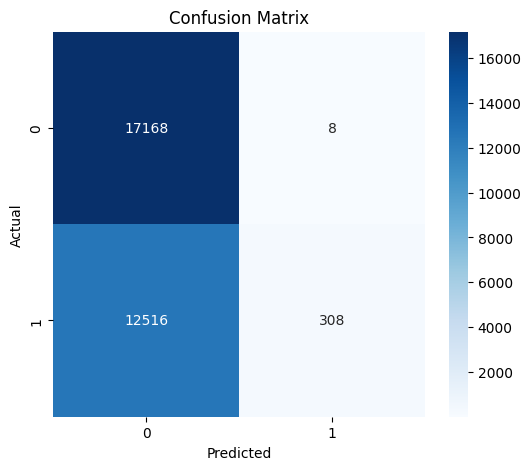

BATCH 4 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4072, Val Loss: 0.3800
Epoch 2/10, Train Loss: 0.4083, Val Loss: 0.3853
Epoch 3/10, Train Loss: 0.3977, Val Loss: 0.3840
Epoch 4/10, Train Loss: 0.3849, Val Loss: 0.3763
Epoch 5/10, Train Loss: 0.3797, Val Loss: 0.3643
Epoch 6/10, Train Loss: 0.3780, Val Loss: 0.3842
Epoch 7/10, Train Loss: 0.3828, Val Loss: 0.3552
Epoch 8/10, Train Loss: 0.3632, Val Loss: 0.3553
Epoch 9/10, Train Loss: 0.3617, Val Loss: 0.3476
Epoch 10/10, Train Loss: 0.3665, Val Loss: 0.3546
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5729
Confusion Matrix:
[[16901    64]
 [12750   285]]


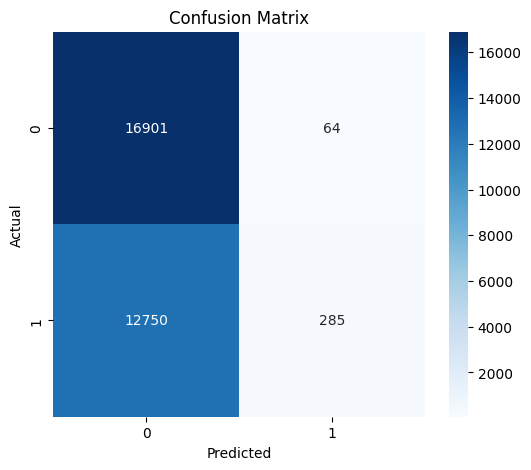

BATCH 5 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4025, Val Loss: 0.4001
Epoch 2/10, Train Loss: 0.3912, Val Loss: 0.3871
Epoch 3/10, Train Loss: 0.3887, Val Loss: 0.3894
Epoch 4/10, Train Loss: 0.3875, Val Loss: 0.3665
Epoch 5/10, Train Loss: 0.3676, Val Loss: 0.3524
Epoch 6/10, Train Loss: 0.3632, Val Loss: 0.3525
Epoch 7/10, Train Loss: 0.3618, Val Loss: 0.3670
Epoch 8/10, Train Loss: 0.3589, Val Loss: 0.3399
Epoch 9/10, Train Loss: 0.3487, Val Loss: 0.3348
Epoch 10/10, Train Loss: 0.3545, Val Loss: 0.3627
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5946
Confusion Matrix:
[[17379    89]
 [12073   459]]


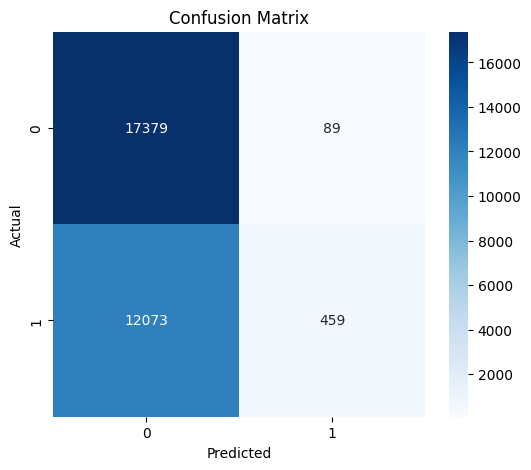

BATCH 6 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3902, Val Loss: 0.3887
Epoch 2/10, Train Loss: 0.3741, Val Loss: 0.3507
Epoch 3/10, Train Loss: 0.3584, Val Loss: 0.3444
Epoch 4/10, Train Loss: 0.3495, Val Loss: 0.3331
Epoch 5/10, Train Loss: 0.3578, Val Loss: 0.3446
Epoch 6/10, Train Loss: 0.3480, Val Loss: 0.3289
Epoch 7/10, Train Loss: 0.3444, Val Loss: 0.3394
Epoch 8/10, Train Loss: 0.3429, Val Loss: 0.3343
Epoch 9/10, Train Loss: 0.3343, Val Loss: 0.3265
Epoch 10/10, Train Loss: 0.3489, Val Loss: 0.3558
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5882
Confusion Matrix:
[[17273   101]
 [12254   372]]


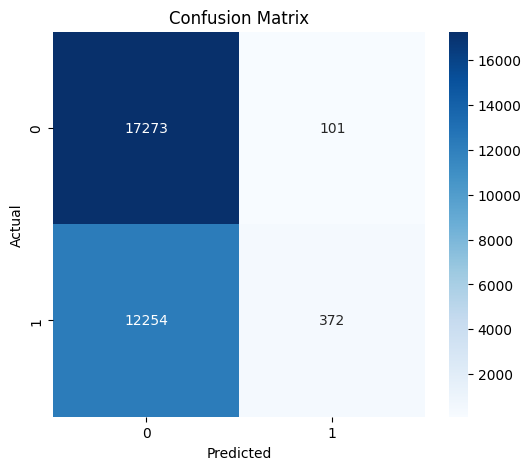

BATCH 7 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3898, Val Loss: 0.3800
Epoch 2/10, Train Loss: 0.3704, Val Loss: 0.3616
Epoch 3/10, Train Loss: 0.3502, Val Loss: 0.3441
Epoch 4/10, Train Loss: 0.3530, Val Loss: 0.3566
Epoch 5/10, Train Loss: 0.3531, Val Loss: 0.3652
Epoch 6/10, Train Loss: 0.3624, Val Loss: 0.3404
Epoch 7/10, Train Loss: 0.3420, Val Loss: 0.3351
Epoch 8/10, Train Loss: 0.3466, Val Loss: 0.3217
Epoch 9/10, Train Loss: 0.3288, Val Loss: 0.3155
Epoch 10/10, Train Loss: 0.3264, Val Loss: 0.3085
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5782
Confusion Matrix:
[[17091    20]
 [12635   254]]


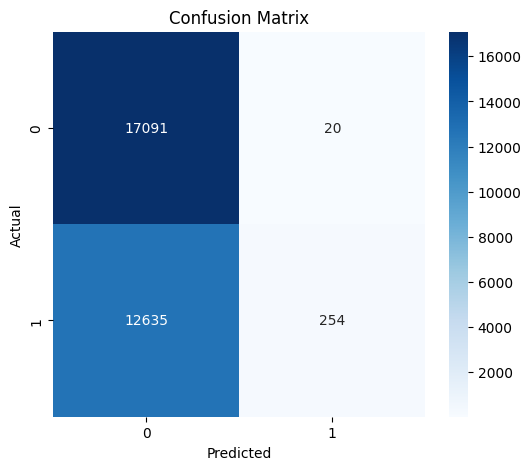

BATCH 8 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3791, Val Loss: 0.3660
Epoch 2/10, Train Loss: 0.3660, Val Loss: 0.3539
Epoch 3/10, Train Loss: 0.3485, Val Loss: 0.3358
Epoch 4/10, Train Loss: 0.3368, Val Loss: 0.3380
Epoch 5/10, Train Loss: 0.3606, Val Loss: 0.3338
Epoch 6/10, Train Loss: 0.3456, Val Loss: 0.3279
Epoch 7/10, Train Loss: 0.3419, Val Loss: 0.3322
Epoch 8/10, Train Loss: 0.3314, Val Loss: 0.3536
Epoch 9/10, Train Loss: 0.3475, Val Loss: 0.3331
Epoch 10/10, Train Loss: 0.3321, Val Loss: 0.3259
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5512
Confusion Matrix:
[[16229    56]
 [13409   306]]


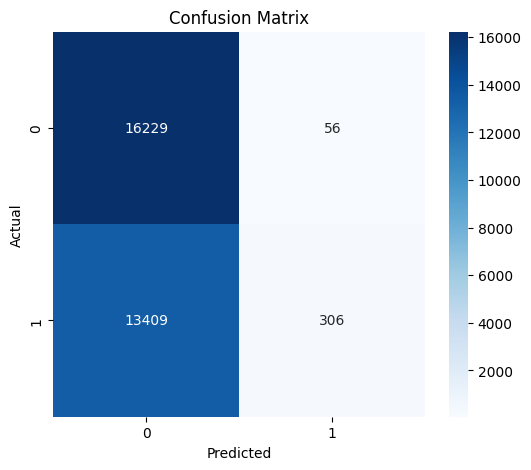

BATCH 9 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3677, Val Loss: 0.3558
Epoch 2/10, Train Loss: 0.3467, Val Loss: 0.3264
Epoch 3/10, Train Loss: 0.3332, Val Loss: 0.3326
Epoch 4/10, Train Loss: 0.3336, Val Loss: 0.3229
Epoch 5/10, Train Loss: 0.3243, Val Loss: 0.3187
Epoch 6/10, Train Loss: 0.3259, Val Loss: 0.3106
Epoch 7/10, Train Loss: 0.3144, Val Loss: 0.3063
Epoch 8/10, Train Loss: 0.3105, Val Loss: 0.3228
Epoch 9/10, Train Loss: 0.3239, Val Loss: 0.3023
Epoch 10/10, Train Loss: 0.3137, Val Loss: 0.2979
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.6090
Confusion Matrix:
[[18035    25]
 [11705   235]]


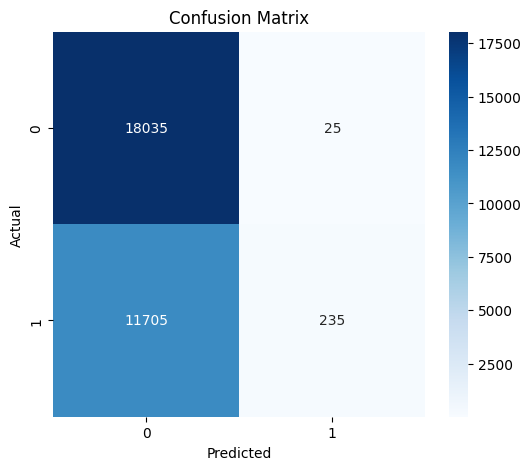

BATCH 10 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3999, Val Loss: 0.3776
Epoch 2/10, Train Loss: 0.3840, Val Loss: 0.3623
Epoch 3/10, Train Loss: 0.3716, Val Loss: 0.3507
Epoch 4/10, Train Loss: 0.3629, Val Loss: 0.3457
Epoch 5/10, Train Loss: 0.3540, Val Loss: 0.3333
Epoch 6/10, Train Loss: 0.3438, Val Loss: 0.3393
Epoch 7/10, Train Loss: 0.3385, Val Loss: 0.3292
Epoch 8/10, Train Loss: 0.3482, Val Loss: 0.3301
Epoch 9/10, Train Loss: 0.3431, Val Loss: 0.3269
Epoch 10/10, Train Loss: 0.3388, Val Loss: 0.3316
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5666
Confusion Matrix:
[[16740   105]
 [12896   259]]


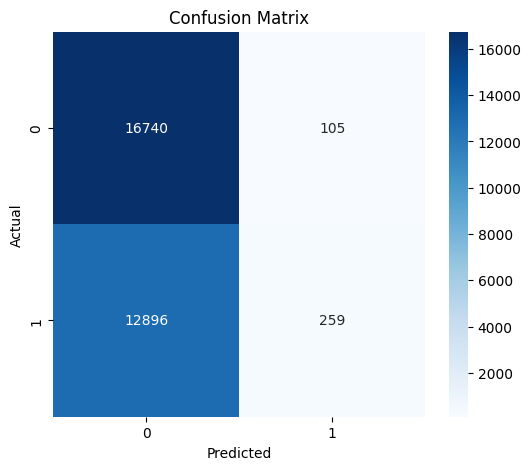

BATCH 11 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3884, Val Loss: 0.3674
Epoch 2/10, Train Loss: 0.3758, Val Loss: 0.3742
Epoch 3/10, Train Loss: 0.3681, Val Loss: 0.3567
Epoch 4/10, Train Loss: 0.3715, Val Loss: 0.3429
Epoch 5/10, Train Loss: 0.3501, Val Loss: 0.3490
Epoch 6/10, Train Loss: 0.3460, Val Loss: 0.3372
Epoch 7/10, Train Loss: 0.3449, Val Loss: 0.3333
Epoch 8/10, Train Loss: 0.3382, Val Loss: 0.3491
Epoch 9/10, Train Loss: 0.3339, Val Loss: 0.3395
Epoch 10/10, Train Loss: 0.3411, Val Loss: 0.3209
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5653
Confusion Matrix:
[[16620    60]
 [12981   339]]


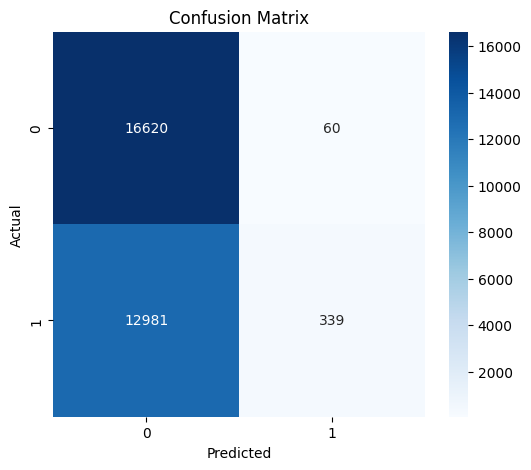

BATCH 12 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3645, Val Loss: 0.3570
Epoch 2/10, Train Loss: 0.3464, Val Loss: 0.3275
Epoch 3/10, Train Loss: 0.3391, Val Loss: 0.3127
Epoch 4/10, Train Loss: 0.3287, Val Loss: 0.3087
Epoch 5/10, Train Loss: 0.3279, Val Loss: 0.3109
Epoch 6/10, Train Loss: 0.3164, Val Loss: 0.2996
Epoch 7/10, Train Loss: 0.3103, Val Loss: 0.2955
Epoch 8/10, Train Loss: 0.3064, Val Loss: 0.2954
Epoch 9/10, Train Loss: 0.3031, Val Loss: 0.2876
Epoch 10/10, Train Loss: 0.2975, Val Loss: 0.2875
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.6286
Confusion Matrix:
[[18468    16]
 [11125   391]]


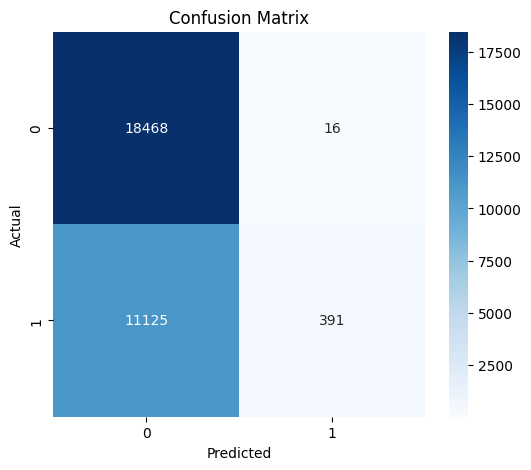

BATCH 13 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3974, Val Loss: 0.3542
Epoch 2/10, Train Loss: 0.3691, Val Loss: 0.3498
Epoch 3/10, Train Loss: 0.3486, Val Loss: 0.3400
Epoch 4/10, Train Loss: 0.3414, Val Loss: 0.3273
Epoch 5/10, Train Loss: 0.3270, Val Loss: 0.3180
Epoch 6/10, Train Loss: 0.3269, Val Loss: 0.3191
Epoch 7/10, Train Loss: 0.3206, Val Loss: 0.3075
Epoch 8/10, Train Loss: 0.3306, Val Loss: 0.3167
Epoch 9/10, Train Loss: 0.3226, Val Loss: 0.3088
Epoch 10/10, Train Loss: 0.3141, Val Loss: 0.3078
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5814
Confusion Matrix:
[[17095    23]
 [12536   346]]


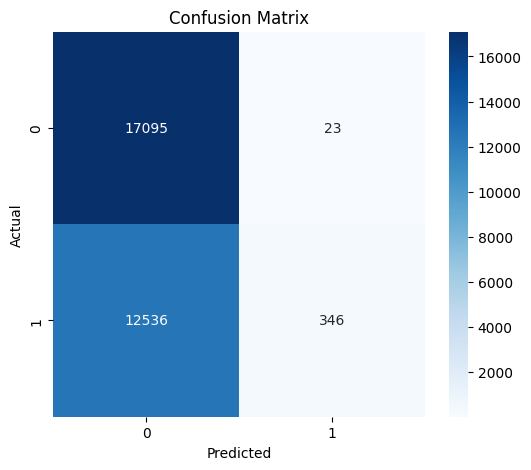

BATCH 14 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3886, Val Loss: 0.3585
Epoch 2/10, Train Loss: 0.3635, Val Loss: 0.3785
Epoch 3/10, Train Loss: 0.3520, Val Loss: 0.3433
Epoch 4/10, Train Loss: 0.3445, Val Loss: 0.3362
Epoch 5/10, Train Loss: 0.3484, Val Loss: 0.3438
Epoch 6/10, Train Loss: 0.3342, Val Loss: 0.3211
Epoch 7/10, Train Loss: 0.3280, Val Loss: 0.3172
Epoch 8/10, Train Loss: 0.3237, Val Loss: 0.3084
Epoch 9/10, Train Loss: 0.3256, Val Loss: 0.3167
Epoch 10/10, Train Loss: 0.3244, Val Loss: 0.3124
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5726
Confusion Matrix:
[[16902     9]
 [12814   275]]


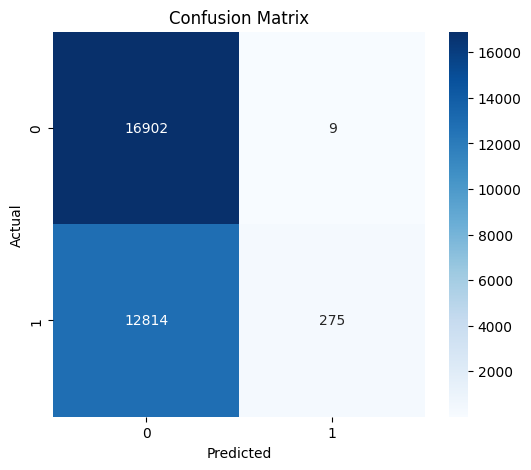

BATCH 15 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3713, Val Loss: 0.3418
Epoch 2/10, Train Loss: 0.3432, Val Loss: 0.3288
Epoch 3/10, Train Loss: 0.3265, Val Loss: 0.3146
Epoch 4/10, Train Loss: 0.3253, Val Loss: 0.3198
Epoch 5/10, Train Loss: 0.3289, Val Loss: 0.3233
Epoch 6/10, Train Loss: 0.3181, Val Loss: 0.3022
Epoch 7/10, Train Loss: 0.3131, Val Loss: 0.2908
Epoch 8/10, Train Loss: 0.3017, Val Loss: 0.2921
Epoch 9/10, Train Loss: 0.3021, Val Loss: 0.2999
Epoch 10/10, Train Loss: 0.3064, Val Loss: 0.2974
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5936
Confusion Matrix:
[[17499    67]
 [12125   309]]


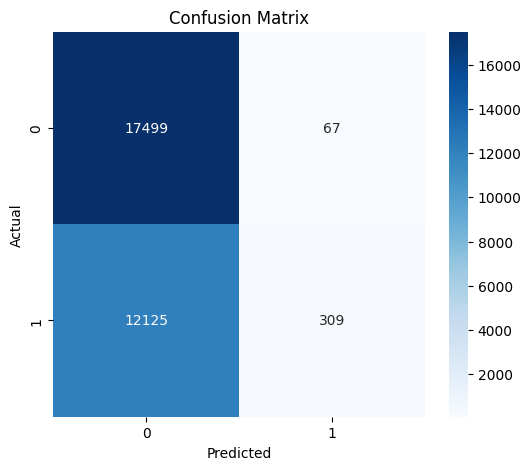

BATCH 16 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3774, Val Loss: 0.3504
Epoch 2/10, Train Loss: 0.3465, Val Loss: 0.3320
Epoch 3/10, Train Loss: 0.3354, Val Loss: 0.3245
Epoch 4/10, Train Loss: 0.3402, Val Loss: 0.3233
Epoch 5/10, Train Loss: 0.3414, Val Loss: 0.3194
Epoch 6/10, Train Loss: 0.3259, Val Loss: 0.3051
Epoch 7/10, Train Loss: 0.3119, Val Loss: 0.3121
Epoch 8/10, Train Loss: 0.3089, Val Loss: 0.3008
Epoch 9/10, Train Loss: 0.3084, Val Loss: 0.3142
Epoch 10/10, Train Loss: 0.3099, Val Loss: 0.3044
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5936
Confusion Matrix:
[[17575    15]
 [12178   232]]


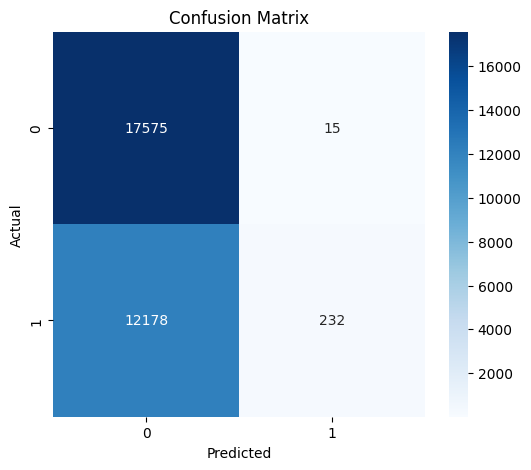

BATCH 17 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3739, Val Loss: 0.3367
Epoch 2/10, Train Loss: 0.3486, Val Loss: 0.3255
Epoch 3/10, Train Loss: 0.3419, Val Loss: 0.3283
Epoch 4/10, Train Loss: 0.3217, Val Loss: 0.3182
Epoch 5/10, Train Loss: 0.3194, Val Loss: 0.3200
Epoch 6/10, Train Loss: 0.3146, Val Loss: 0.3018
Epoch 7/10, Train Loss: 0.3131, Val Loss: 0.3038
Epoch 8/10, Train Loss: 0.3143, Val Loss: 0.2986
Epoch 9/10, Train Loss: 0.3024, Val Loss: 0.2932
Epoch 10/10, Train Loss: 0.2960, Val Loss: 0.2875
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5915
Confusion Matrix:
[[17397    23]
 [12233   347]]


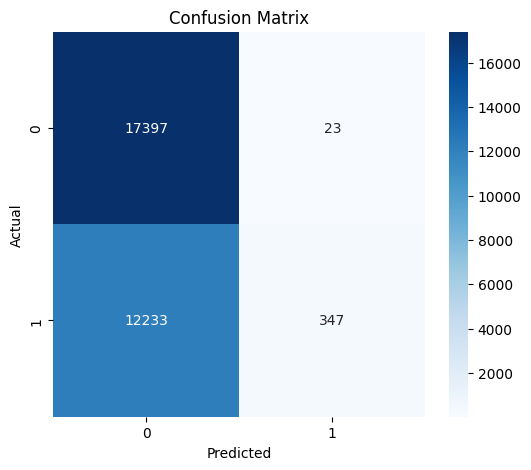

BATCH 18 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3398, Val Loss: 0.3312
Epoch 2/10, Train Loss: 0.3171, Val Loss: 0.3099
Epoch 3/10, Train Loss: 0.3124, Val Loss: 0.3029
Epoch 4/10, Train Loss: 0.3123, Val Loss: 0.3084
Epoch 5/10, Train Loss: 0.3064, Val Loss: 0.2934
Epoch 6/10, Train Loss: 0.2956, Val Loss: 0.2741
Epoch 7/10, Train Loss: 0.2879, Val Loss: 0.2760
Epoch 8/10, Train Loss: 0.2923, Val Loss: 0.2878
Epoch 9/10, Train Loss: 0.2799, Val Loss: 0.2691
Epoch 10/10, Train Loss: 0.2775, Val Loss: 0.2733
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5924
Confusion Matrix:
[[17497    81]
 [12148   274]]


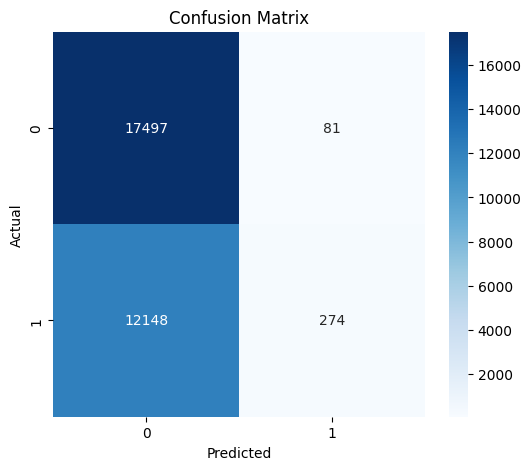

BATCH 19 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3510, Val Loss: 0.3326
Epoch 2/10, Train Loss: 0.3267, Val Loss: 0.3162
Epoch 3/10, Train Loss: 0.3069, Val Loss: 0.3085
Epoch 4/10, Train Loss: 0.3120, Val Loss: 0.3160
Epoch 5/10, Train Loss: 0.3192, Val Loss: 0.2945
Epoch 6/10, Train Loss: 0.3020, Val Loss: 0.2969
Epoch 7/10, Train Loss: 0.3024, Val Loss: 0.2907
Epoch 8/10, Train Loss: 0.2969, Val Loss: 0.2946
Epoch 9/10, Train Loss: 0.2862, Val Loss: 0.2917
Epoch 10/10, Train Loss: 0.3015, Val Loss: 0.2940
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5846
Confusion Matrix:
[[16998    61]
 [12402   539]]


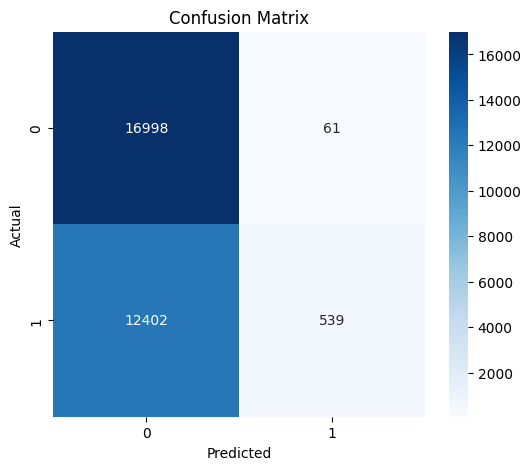

BATCH 20 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4004, Val Loss: 0.3637
Epoch 2/10, Train Loss: 0.3731, Val Loss: 0.3649
Epoch 3/10, Train Loss: 0.3696, Val Loss: 0.3612
Epoch 4/10, Train Loss: 0.3647, Val Loss: 0.3557
Epoch 5/10, Train Loss: 0.3609, Val Loss: 0.3524
Epoch 6/10, Train Loss: 0.3503, Val Loss: 0.3425
Epoch 7/10, Train Loss: 0.3495, Val Loss: 0.3468
Epoch 8/10, Train Loss: 0.3494, Val Loss: 0.3425
Epoch 9/10, Train Loss: 0.3400, Val Loss: 0.3333
Epoch 10/10, Train Loss: 0.3386, Val Loss: 0.3329
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5760
Confusion Matrix:
[[16937    84]
 [12637   342]]


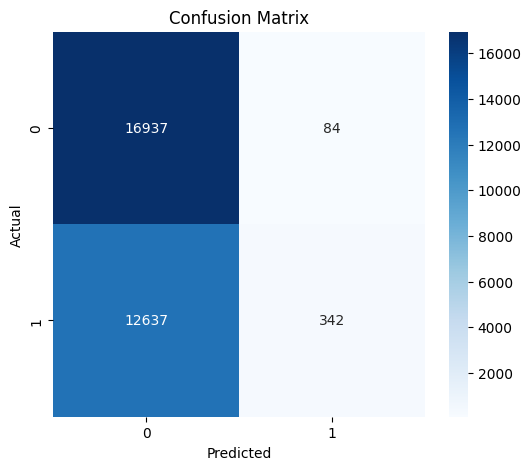

BATCH 21 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3803, Val Loss: 0.3511
Epoch 2/10, Train Loss: 0.3546, Val Loss: 0.3535
Epoch 3/10, Train Loss: 0.3466, Val Loss: 0.3319
Epoch 4/10, Train Loss: 0.3501, Val Loss: 0.3379
Epoch 5/10, Train Loss: 0.3390, Val Loss: 0.3260
Epoch 6/10, Train Loss: 0.3300, Val Loss: 0.3172
Epoch 7/10, Train Loss: 0.3195, Val Loss: 0.3213
Epoch 8/10, Train Loss: 0.3153, Val Loss: 0.3058
Epoch 9/10, Train Loss: 0.3104, Val Loss: 0.3084
Epoch 10/10, Train Loss: 0.3212, Val Loss: 0.3087
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5923
Confusion Matrix:
[[17377    86]
 [12145   392]]


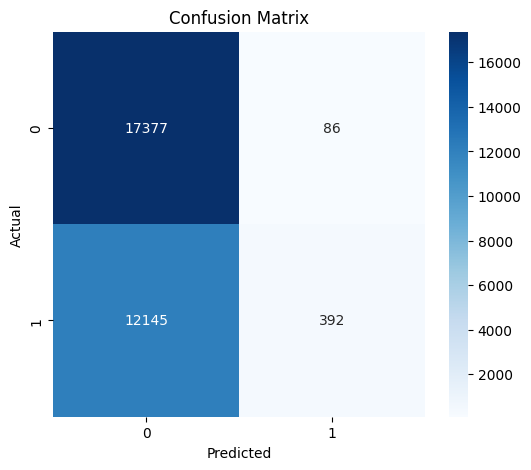

BATCH 22 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3636, Val Loss: 0.3399
Epoch 2/10, Train Loss: 0.3225, Val Loss: 0.3094
Epoch 3/10, Train Loss: 0.3168, Val Loss: 0.3081
Epoch 4/10, Train Loss: 0.3114, Val Loss: 0.3143
Epoch 5/10, Train Loss: 0.3054, Val Loss: 0.2921
Epoch 6/10, Train Loss: 0.2931, Val Loss: 0.2848
Epoch 7/10, Train Loss: 0.2933, Val Loss: 0.2814
Epoch 8/10, Train Loss: 0.2937, Val Loss: 0.3142
Epoch 9/10, Train Loss: 0.3065, Val Loss: 0.2721
Epoch 10/10, Train Loss: 0.2758, Val Loss: 0.2624
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5630
Confusion Matrix:
[[16415    63]
 [13046   476]]


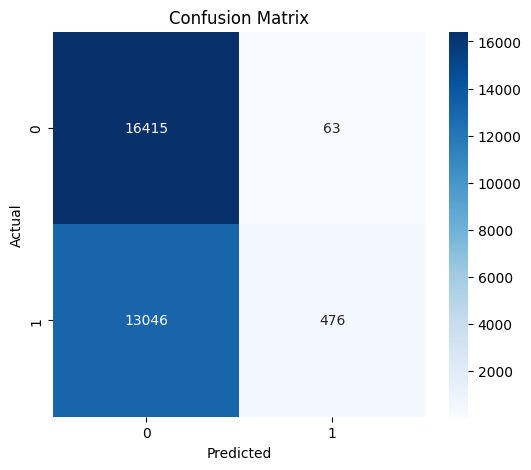

BATCH 23 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3420, Val Loss: 0.3314
Epoch 2/10, Train Loss: 0.3307, Val Loss: 0.3094
Epoch 3/10, Train Loss: 0.3161, Val Loss: 0.3028
Epoch 4/10, Train Loss: 0.3041, Val Loss: 0.2953
Epoch 5/10, Train Loss: 0.3166, Val Loss: 0.3068
Epoch 6/10, Train Loss: 0.3086, Val Loss: 0.2987
Epoch 7/10, Train Loss: 0.2994, Val Loss: 0.2886
Epoch 8/10, Train Loss: 0.2923, Val Loss: 0.2912
Epoch 9/10, Train Loss: 0.2793, Val Loss: 0.2633
Epoch 10/10, Train Loss: 0.2756, Val Loss: 0.2623
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.6234
Confusion Matrix:
[[18365    42]
 [11256   337]]


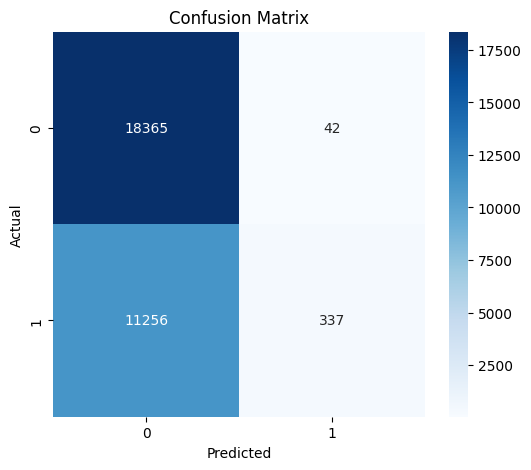

BATCH 24 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3690, Val Loss: 0.3404
Epoch 2/10, Train Loss: 0.3475, Val Loss: 0.3288
Epoch 3/10, Train Loss: 0.3370, Val Loss: 0.3195
Epoch 4/10, Train Loss: 0.3254, Val Loss: 0.3061
Epoch 5/10, Train Loss: 0.3091, Val Loss: 0.3105
Epoch 6/10, Train Loss: 0.3130, Val Loss: 0.3286
Epoch 7/10, Train Loss: 0.3299, Val Loss: 0.3121
Epoch 8/10, Train Loss: 0.3166, Val Loss: 0.2900
Epoch 9/10, Train Loss: 0.3182, Val Loss: 0.2995
Epoch 10/10, Train Loss: 0.2937, Val Loss: 0.3024
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.6015
Confusion Matrix:
[[17759    76]
 [11879   286]]


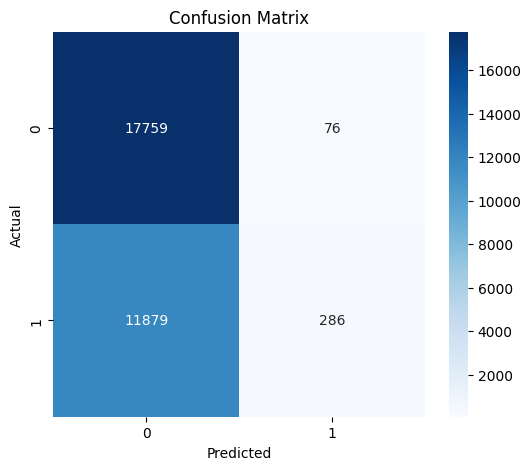

BATCH 25 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3444, Val Loss: 0.3196
Epoch 2/10, Train Loss: 0.3191, Val Loss: 0.3060
Epoch 3/10, Train Loss: 0.3091, Val Loss: 0.2949
Epoch 4/10, Train Loss: 0.2962, Val Loss: 0.2880
Epoch 5/10, Train Loss: 0.3051, Val Loss: 0.2923
Epoch 6/10, Train Loss: 0.3023, Val Loss: 0.2880
Epoch 7/10, Train Loss: 0.2984, Val Loss: 0.2960
Epoch 8/10, Train Loss: 0.2864, Val Loss: 0.2771
Epoch 9/10, Train Loss: 0.2793, Val Loss: 0.2687
Epoch 10/10, Train Loss: 0.2841, Val Loss: 0.2736
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5806
Confusion Matrix:
[[17231    58]
 [12525   186]]


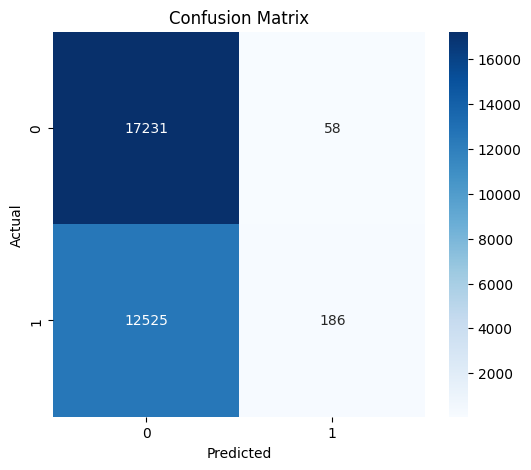

BATCH 26 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3574, Val Loss: 0.3163
Epoch 2/10, Train Loss: 0.3283, Val Loss: 0.3118
Epoch 3/10, Train Loss: 0.3097, Val Loss: 0.2996
Epoch 4/10, Train Loss: 0.3040, Val Loss: 0.2982
Epoch 5/10, Train Loss: 0.3008, Val Loss: 0.2796
Epoch 6/10, Train Loss: 0.2894, Val Loss: 0.2850
Epoch 7/10, Train Loss: 0.2859, Val Loss: 0.2714
Epoch 8/10, Train Loss: 0.2893, Val Loss: 0.2736
Epoch 9/10, Train Loss: 0.2864, Val Loss: 0.2868
Epoch 10/10, Train Loss: 0.2933, Val Loss: 0.2725
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5578
Confusion Matrix:
[[16393   149]
 [13116   342]]


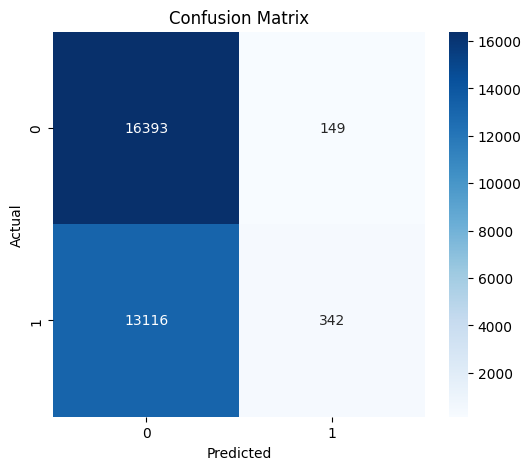

BATCH 27 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4028, Val Loss: 0.3614
Epoch 2/10, Train Loss: 0.3632, Val Loss: 0.3457
Epoch 3/10, Train Loss: 0.3499, Val Loss: 0.3304
Epoch 4/10, Train Loss: 0.3390, Val Loss: 0.3229
Epoch 5/10, Train Loss: 0.3326, Val Loss: 0.3190
Epoch 6/10, Train Loss: 0.3220, Val Loss: 0.3073
Epoch 7/10, Train Loss: 0.3208, Val Loss: 0.3056
Epoch 8/10, Train Loss: 0.3218, Val Loss: 0.3086
Epoch 9/10, Train Loss: 0.3081, Val Loss: 0.2942
Epoch 10/10, Train Loss: 0.3011, Val Loss: 0.2892
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5578
Confusion Matrix:
[[16409    28]
 [13238   325]]


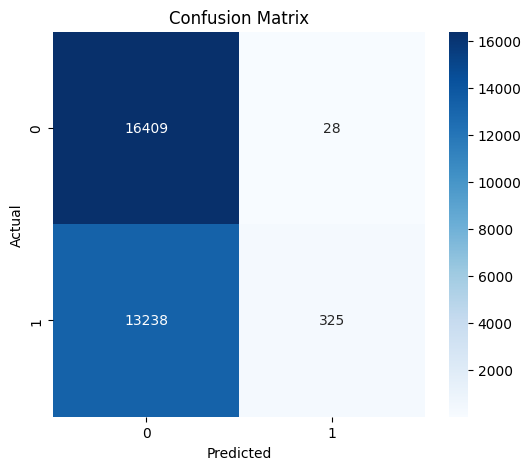

BATCH 28 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3765, Val Loss: 0.3505
Epoch 2/10, Train Loss: 0.3484, Val Loss: 0.3356
Epoch 3/10, Train Loss: 0.3439, Val Loss: 0.3203
Epoch 4/10, Train Loss: 0.3296, Val Loss: 0.3218
Epoch 5/10, Train Loss: 0.3251, Val Loss: 0.3192
Epoch 6/10, Train Loss: 0.3258, Val Loss: 0.3021
Epoch 7/10, Train Loss: 0.3117, Val Loss: 0.3042
Epoch 8/10, Train Loss: 0.3077, Val Loss: 0.3014
Epoch 9/10, Train Loss: 0.3066, Val Loss: 0.2894
Epoch 10/10, Train Loss: 0.2982, Val Loss: 0.3031
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5882
Confusion Matrix:
[[17404    25]
 [12330   241]]


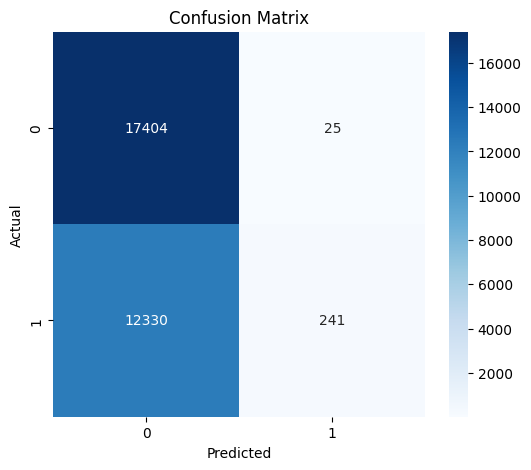

BATCH 29 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3932, Val Loss: 0.3731
Epoch 2/10, Train Loss: 0.3732, Val Loss: 0.3547
Epoch 3/10, Train Loss: 0.3517, Val Loss: 0.3368
Epoch 4/10, Train Loss: 0.3492, Val Loss: 0.3380
Epoch 5/10, Train Loss: 0.3387, Val Loss: 0.3183
Epoch 6/10, Train Loss: 0.3238, Val Loss: 0.3162
Epoch 7/10, Train Loss: 0.3222, Val Loss: 0.3152
Epoch 8/10, Train Loss: 0.3278, Val Loss: 0.3156
Epoch 9/10, Train Loss: 0.3258, Val Loss: 0.3041
Epoch 10/10, Train Loss: 0.3161, Val Loss: 0.3099
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5594
Confusion Matrix:
[[16523    31]
 [13187   259]]


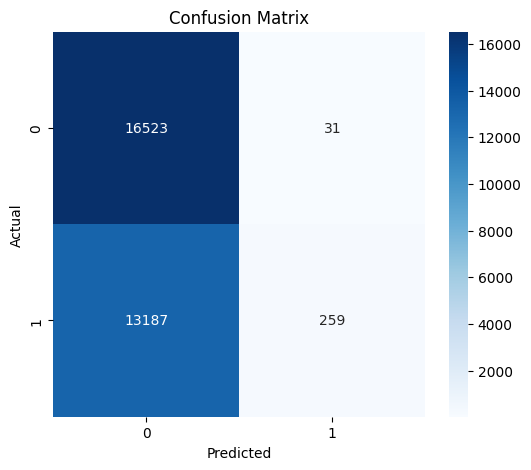

BATCH 30 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3872, Val Loss: 0.3558
Epoch 2/10, Train Loss: 0.3584, Val Loss: 0.3478
Epoch 3/10, Train Loss: 0.3447, Val Loss: 0.3341
Epoch 4/10, Train Loss: 0.3343, Val Loss: 0.3226
Epoch 5/10, Train Loss: 0.3330, Val Loss: 0.3183
Epoch 6/10, Train Loss: 0.3335, Val Loss: 0.3166
Epoch 7/10, Train Loss: 0.3227, Val Loss: 0.3189
Epoch 8/10, Train Loss: 0.3113, Val Loss: 0.3053
Epoch 9/10, Train Loss: 0.3126, Val Loss: 0.3148
Epoch 10/10, Train Loss: 0.3240, Val Loss: 0.3025
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5747
Confusion Matrix:
[[16874    52]
 [12706   368]]


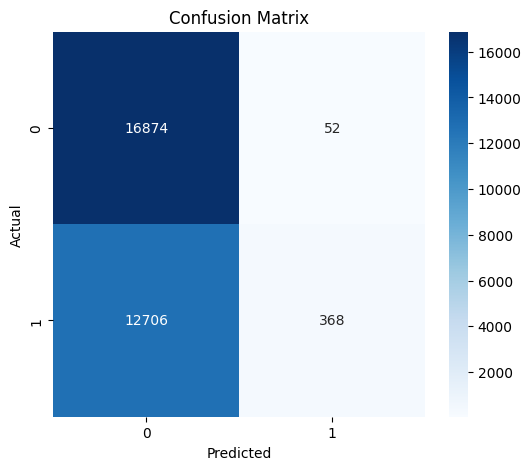

BATCH 31 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3805, Val Loss: 0.3548
Epoch 2/10, Train Loss: 0.3494, Val Loss: 0.3372
Epoch 3/10, Train Loss: 0.3398, Val Loss: 0.3312
Epoch 4/10, Train Loss: 0.3312, Val Loss: 0.3241
Epoch 5/10, Train Loss: 0.3249, Val Loss: 0.3140
Epoch 6/10, Train Loss: 0.3182, Val Loss: 0.3308
Epoch 7/10, Train Loss: 0.3169, Val Loss: 0.3127
Epoch 8/10, Train Loss: 0.3207, Val Loss: 0.3058
Epoch 9/10, Train Loss: 0.3280, Val Loss: 0.3108
Epoch 10/10, Train Loss: 0.3234, Val Loss: 0.3180
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5693
Confusion Matrix:
[[16829    48]
 [12873   250]]


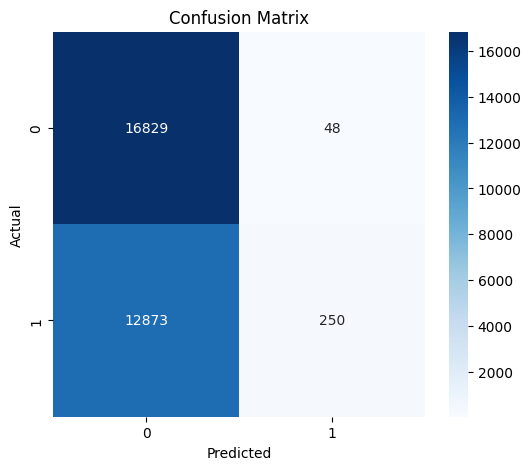

BATCH 32 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3359, Val Loss: 0.3124
Epoch 2/10, Train Loss: 0.3111, Val Loss: 0.2983
Epoch 3/10, Train Loss: 0.2984, Val Loss: 0.2901
Epoch 4/10, Train Loss: 0.2911, Val Loss: 0.2776
Epoch 5/10, Train Loss: 0.2804, Val Loss: 0.2668
Epoch 6/10, Train Loss: 0.2813, Val Loss: 0.2787
Epoch 7/10, Train Loss: 0.2698, Val Loss: 0.2770
Epoch 8/10, Train Loss: 0.2621, Val Loss: 0.2549
Epoch 9/10, Train Loss: 0.2902, Val Loss: 0.2768
Epoch 10/10, Train Loss: 0.2826, Val Loss: 0.2708
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.6274
Confusion Matrix:
[[18528    10]
 [11168   294]]


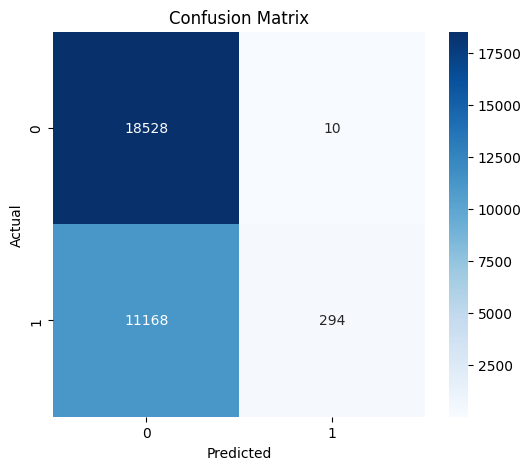

BATCH 33 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3785, Val Loss: 0.3554
Epoch 2/10, Train Loss: 0.3702, Val Loss: 0.3515
Epoch 3/10, Train Loss: 0.3541, Val Loss: 0.3298
Epoch 4/10, Train Loss: 0.3300, Val Loss: 0.3166
Epoch 5/10, Train Loss: 0.3196, Val Loss: 0.3205
Epoch 6/10, Train Loss: 0.3157, Val Loss: 0.3073
Epoch 7/10, Train Loss: 0.3147, Val Loss: 0.3057
Epoch 8/10, Train Loss: 0.3106, Val Loss: 0.2933
Epoch 9/10, Train Loss: 0.3040, Val Loss: 0.2886
Epoch 10/10, Train Loss: 0.2997, Val Loss: 0.2860
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5973
Confusion Matrix:
[[17577    47]
 [12035   341]]


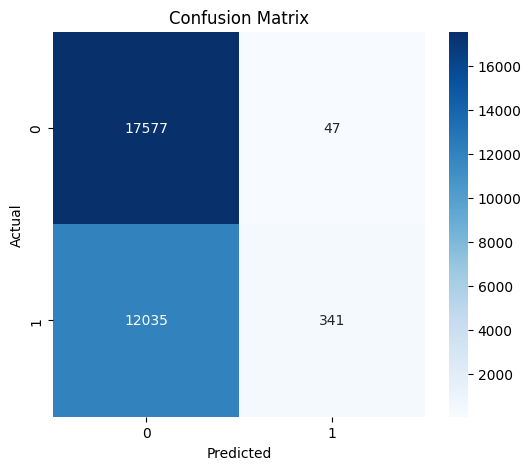

BATCH 34 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3726, Val Loss: 0.3410
Epoch 2/10, Train Loss: 0.3542, Val Loss: 0.3306
Epoch 3/10, Train Loss: 0.3305, Val Loss: 0.3168
Epoch 4/10, Train Loss: 0.3227, Val Loss: 0.3015
Epoch 5/10, Train Loss: 0.3157, Val Loss: 0.2973
Epoch 6/10, Train Loss: 0.3043, Val Loss: 0.2839
Epoch 7/10, Train Loss: 0.2995, Val Loss: 0.2899
Epoch 8/10, Train Loss: 0.2930, Val Loss: 0.2837
Epoch 9/10, Train Loss: 0.2827, Val Loss: 0.2678
Epoch 10/10, Train Loss: 0.2743, Val Loss: 0.2687
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5753
Confusion Matrix:
[[17010    38]
 [12704   248]]


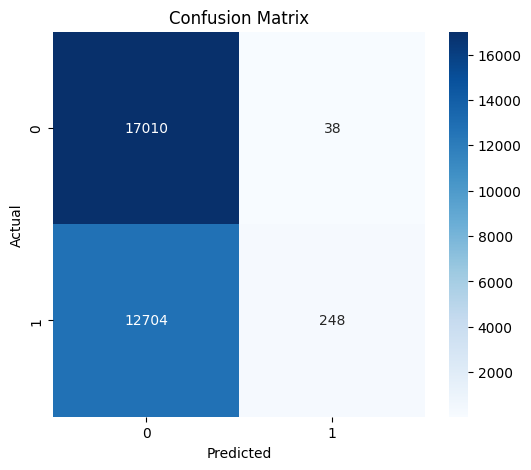

BATCH 35 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3596, Val Loss: 0.3355
Epoch 2/10, Train Loss: 0.3357, Val Loss: 0.3303
Epoch 3/10, Train Loss: 0.3281, Val Loss: 0.3098
Epoch 4/10, Train Loss: 0.3150, Val Loss: 0.3024
Epoch 5/10, Train Loss: 0.3075, Val Loss: 0.2866
Epoch 6/10, Train Loss: 0.2974, Val Loss: 0.2843
Epoch 7/10, Train Loss: 0.2882, Val Loss: 0.2993
Epoch 8/10, Train Loss: 0.2892, Val Loss: 0.2715
Epoch 9/10, Train Loss: 0.2754, Val Loss: 0.2684
Epoch 10/10, Train Loss: 0.2726, Val Loss: 0.2716
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.6025
Confusion Matrix:
[[17779    93]
 [11832   296]]


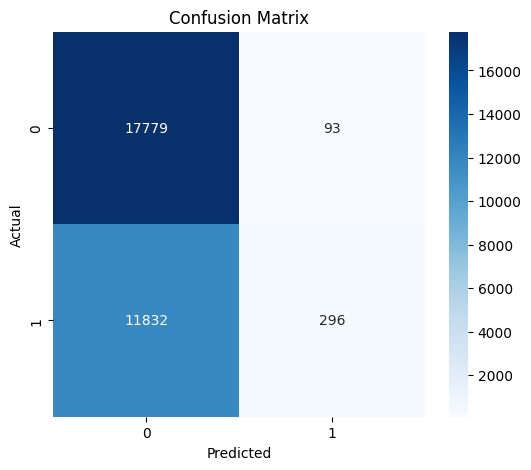

BATCH 36 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3440, Val Loss: 0.3143
Epoch 2/10, Train Loss: 0.3232, Val Loss: 0.3043
Epoch 3/10, Train Loss: 0.3113, Val Loss: 0.3005
Epoch 4/10, Train Loss: 0.3028, Val Loss: 0.2929
Epoch 5/10, Train Loss: 0.2986, Val Loss: 0.2987
Epoch 6/10, Train Loss: 0.2893, Val Loss: 0.2698
Epoch 7/10, Train Loss: 0.2881, Val Loss: 0.2685
Epoch 8/10, Train Loss: 0.2805, Val Loss: 0.2696
Epoch 9/10, Train Loss: 0.2698, Val Loss: 0.2541
Epoch 10/10, Train Loss: 0.2615, Val Loss: 0.2507
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5652
Confusion Matrix:
[[16637   106]
 [12939   318]]


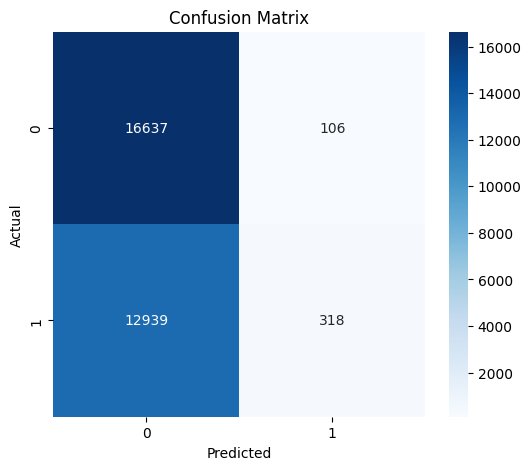

BATCH 37 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3915, Val Loss: 0.3751
Epoch 2/10, Train Loss: 0.3606, Val Loss: 0.3398
Epoch 3/10, Train Loss: 0.3540, Val Loss: 0.3295
Epoch 4/10, Train Loss: 0.3404, Val Loss: 0.3192
Epoch 5/10, Train Loss: 0.3255, Val Loss: 0.3122
Epoch 6/10, Train Loss: 0.3202, Val Loss: 0.3033
Epoch 7/10, Train Loss: 0.3040, Val Loss: 0.3028
Epoch 8/10, Train Loss: 0.3026, Val Loss: 0.2953
Epoch 9/10, Train Loss: 0.2960, Val Loss: 0.2881
Epoch 10/10, Train Loss: 0.3064, Val Loss: 0.2838
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5354
Confusion Matrix:
[[15694    24]
 [13915   367]]


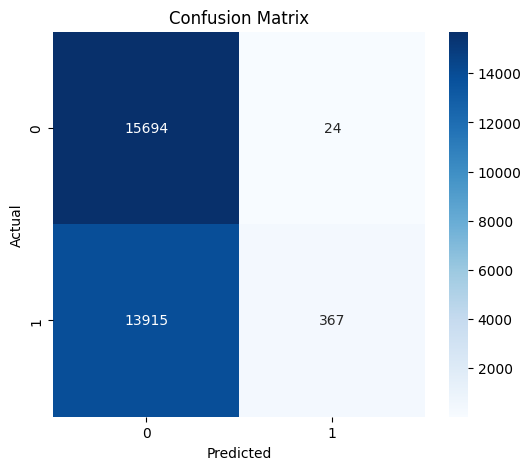

BATCH 38 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3697, Val Loss: 0.3435
Epoch 2/10, Train Loss: 0.3617, Val Loss: 0.3565
Epoch 3/10, Train Loss: 0.3413, Val Loss: 0.3181
Epoch 4/10, Train Loss: 0.3243, Val Loss: 0.3061
Epoch 5/10, Train Loss: 0.3182, Val Loss: 0.3049
Epoch 6/10, Train Loss: 0.3041, Val Loss: 0.2992
Epoch 7/10, Train Loss: 0.2999, Val Loss: 0.2915
Epoch 8/10, Train Loss: 0.2926, Val Loss: 0.2797
Epoch 9/10, Train Loss: 0.2841, Val Loss: 0.3059
Epoch 10/10, Train Loss: 0.2967, Val Loss: 0.2706
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5888
Confusion Matrix:
[[17206   108]
 [12229   457]]


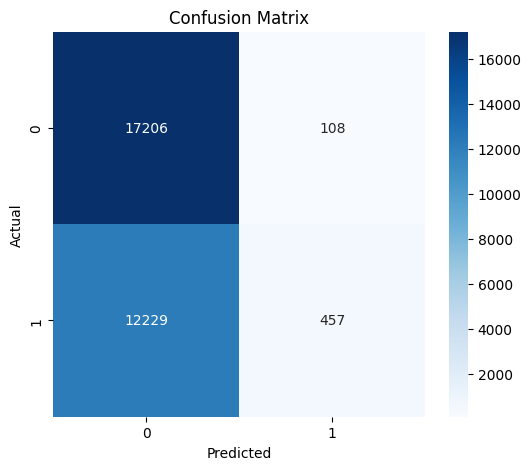

BATCH 39 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3490, Val Loss: 0.3215
Epoch 2/10, Train Loss: 0.3146, Val Loss: 0.3024
Epoch 3/10, Train Loss: 0.2911, Val Loss: 0.2901
Epoch 4/10, Train Loss: 0.2939, Val Loss: 0.2738
Epoch 5/10, Train Loss: 0.2805, Val Loss: 0.2619
Epoch 6/10, Train Loss: 0.2732, Val Loss: 0.2515
Epoch 7/10, Train Loss: 0.2623, Val Loss: 0.2480
Epoch 8/10, Train Loss: 0.2526, Val Loss: 0.2408
Epoch 9/10, Train Loss: 0.2650, Val Loss: 0.2275
Epoch 10/10, Train Loss: 0.2468, Val Loss: 0.2271
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5728
Confusion Matrix:
[[16829    10]
 [12806   355]]


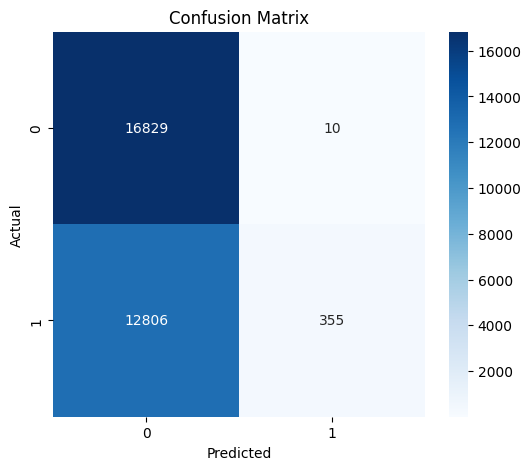

BATCH 40 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3809, Val Loss: 0.3506
Epoch 2/10, Train Loss: 0.3380, Val Loss: 0.3187
Epoch 3/10, Train Loss: 0.3195, Val Loss: 0.3075
Epoch 4/10, Train Loss: 0.3049, Val Loss: 0.2907
Epoch 5/10, Train Loss: 0.2993, Val Loss: 0.2892
Epoch 6/10, Train Loss: 0.2914, Val Loss: 0.2725
Epoch 7/10, Train Loss: 0.2844, Val Loss: 0.2976
Epoch 8/10, Train Loss: 0.2941, Val Loss: 0.2680
Epoch 9/10, Train Loss: 0.2760, Val Loss: 0.2602
Epoch 10/10, Train Loss: 0.2777, Val Loss: 0.2562
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5721
Confusion Matrix:
[[16789    53]
 [12783   375]]


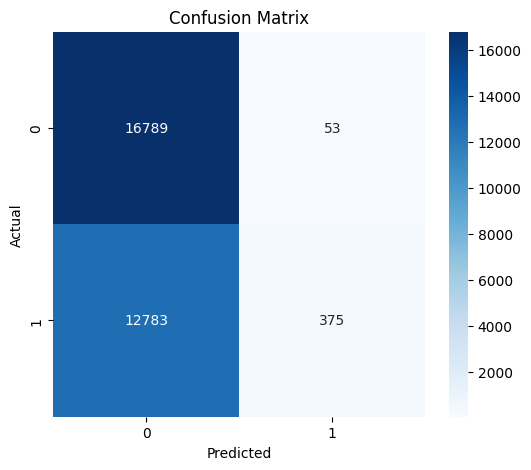

BATCH 41 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3828, Val Loss: 0.3475
Epoch 2/10, Train Loss: 0.3440, Val Loss: 0.3284
Epoch 3/10, Train Loss: 0.3321, Val Loss: 0.3272
Epoch 4/10, Train Loss: 0.3273, Val Loss: 0.3265
Epoch 5/10, Train Loss: 0.3508, Val Loss: 0.3353
Epoch 6/10, Train Loss: 0.3447, Val Loss: 0.3264
Epoch 7/10, Train Loss: 0.3326, Val Loss: 0.3163
Epoch 8/10, Train Loss: 0.3183, Val Loss: 0.3098
Epoch 9/10, Train Loss: 0.3072, Val Loss: 0.2997
Epoch 10/10, Train Loss: 0.3018, Val Loss: 0.2856
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5852
Confusion Matrix:
[[17198    37]
 [12406   359]]


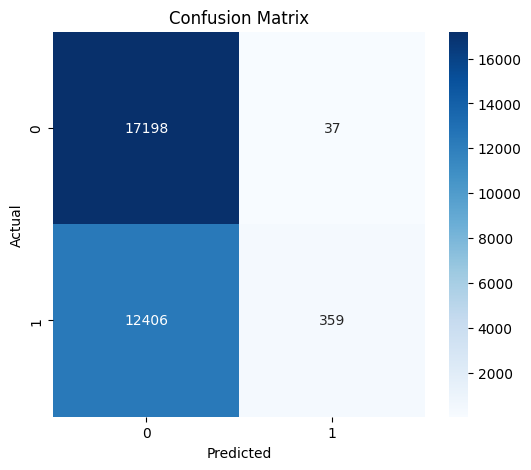

BATCH 42 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3854, Val Loss: 0.3535
Epoch 2/10, Train Loss: 0.3596, Val Loss: 0.3362
Epoch 3/10, Train Loss: 0.3357, Val Loss: 0.3115
Epoch 4/10, Train Loss: 0.3245, Val Loss: 0.3192
Epoch 5/10, Train Loss: 0.3263, Val Loss: 0.3000
Epoch 6/10, Train Loss: 0.3038, Val Loss: 0.2853
Epoch 7/10, Train Loss: 0.2990, Val Loss: 0.2835
Epoch 8/10, Train Loss: 0.3019, Val Loss: 0.2883
Epoch 9/10, Train Loss: 0.2916, Val Loss: 0.2783
Epoch 10/10, Train Loss: 0.2678, Val Loss: 0.2623
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5789
Confusion Matrix:
[[16971   134]
 [12498   397]]


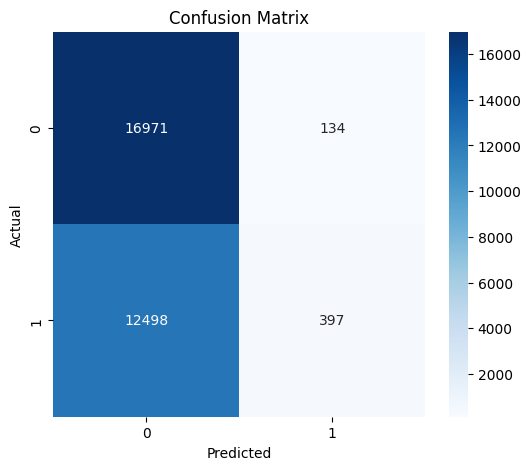

BATCH 43 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3810, Val Loss: 0.3656
Epoch 2/10, Train Loss: 0.3551, Val Loss: 0.3309
Epoch 3/10, Train Loss: 0.3299, Val Loss: 0.3199
Epoch 4/10, Train Loss: 0.3225, Val Loss: 0.3061
Epoch 5/10, Train Loss: 0.3075, Val Loss: 0.3012
Epoch 6/10, Train Loss: 0.2960, Val Loss: 0.2864
Epoch 7/10, Train Loss: 0.2959, Val Loss: 0.2848
Epoch 8/10, Train Loss: 0.2925, Val Loss: 0.2740
Epoch 9/10, Train Loss: 0.2753, Val Loss: 0.2739
Epoch 10/10, Train Loss: 0.2771, Val Loss: 0.2544
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5753
Confusion Matrix:
[[17103    62]
 [12678   157]]


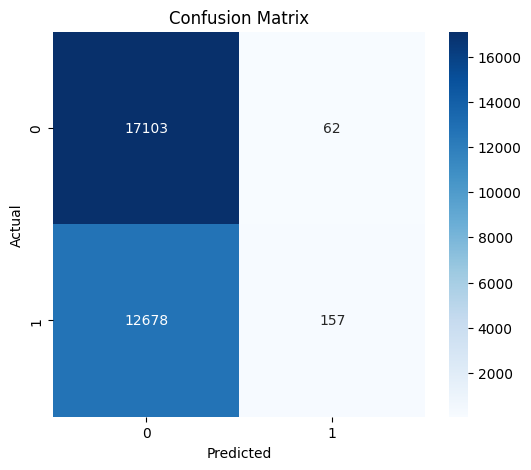

BATCH 44 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4023, Val Loss: 0.3607
Epoch 2/10, Train Loss: 0.3597, Val Loss: 0.3402
Epoch 3/10, Train Loss: 0.3321, Val Loss: 0.3238
Epoch 4/10, Train Loss: 0.3268, Val Loss: 0.3120
Epoch 5/10, Train Loss: 0.3219, Val Loss: 0.3160
Epoch 6/10, Train Loss: 0.3040, Val Loss: 0.2932
Epoch 7/10, Train Loss: 0.2986, Val Loss: 0.2842
Epoch 8/10, Train Loss: 0.3132, Val Loss: 0.2861
Epoch 9/10, Train Loss: 0.2881, Val Loss: 0.2814
Epoch 10/10, Train Loss: 0.2883, Val Loss: 0.2733
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5730
Confusion Matrix:
[[16921    74]
 [12736   269]]


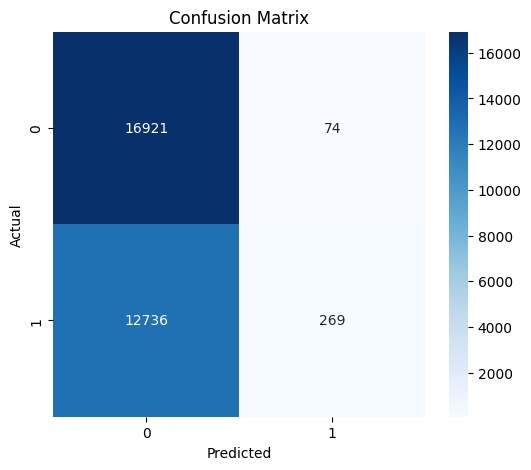

BATCH 45 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3734, Val Loss: 0.3427
Epoch 2/10, Train Loss: 0.3464, Val Loss: 0.3248
Epoch 3/10, Train Loss: 0.3225, Val Loss: 0.3105
Epoch 4/10, Train Loss: 0.3188, Val Loss: 0.2969
Epoch 5/10, Train Loss: 0.3073, Val Loss: 0.2923
Epoch 6/10, Train Loss: 0.2953, Val Loss: 0.2857
Epoch 7/10, Train Loss: 0.2826, Val Loss: 0.2837
Epoch 8/10, Train Loss: 0.2909, Val Loss: 0.2752
Epoch 9/10, Train Loss: 0.2815, Val Loss: 0.2727
Epoch 10/10, Train Loss: 0.2675, Val Loss: 0.2536
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5670
Confusion Matrix:
[[16656    10]
 [12980   354]]


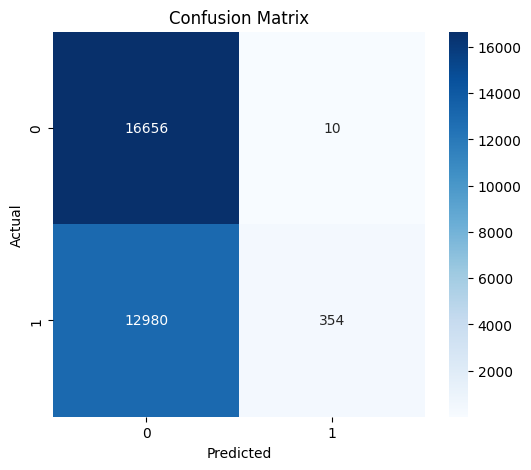

BATCH 46 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4057, Val Loss: 0.3688
Epoch 2/10, Train Loss: 0.3669, Val Loss: 0.3424
Epoch 3/10, Train Loss: 0.3399, Val Loss: 0.3363
Epoch 4/10, Train Loss: 0.3343, Val Loss: 0.3107
Epoch 5/10, Train Loss: 0.3176, Val Loss: 0.3045
Epoch 6/10, Train Loss: 0.3066, Val Loss: 0.2905
Epoch 7/10, Train Loss: 0.3034, Val Loss: 0.2879
Epoch 8/10, Train Loss: 0.2886, Val Loss: 0.2872
Epoch 9/10, Train Loss: 0.2959, Val Loss: 0.2920
Epoch 10/10, Train Loss: 0.2850, Val Loss: 0.2719
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.6020
Confusion Matrix:
[[17818    47]
 [11892   243]]


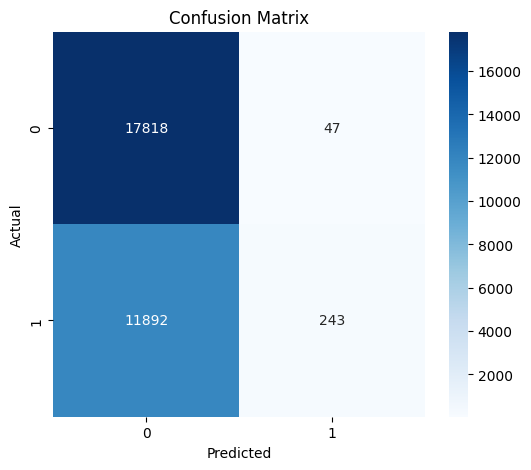

BATCH 47 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3929, Val Loss: 0.3415
Epoch 2/10, Train Loss: 0.3515, Val Loss: 0.3359
Epoch 3/10, Train Loss: 0.3307, Val Loss: 0.3138
Epoch 4/10, Train Loss: 0.3243, Val Loss: 0.3122
Epoch 5/10, Train Loss: 0.3141, Val Loss: 0.3038
Epoch 6/10, Train Loss: 0.3015, Val Loss: 0.2953
Epoch 7/10, Train Loss: 0.2987, Val Loss: 0.2835
Epoch 8/10, Train Loss: 0.3031, Val Loss: 0.2861
Epoch 9/10, Train Loss: 0.2926, Val Loss: 0.2784
Epoch 10/10, Train Loss: 0.2772, Val Loss: 0.2743
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5786
Confusion Matrix:
[[17091    22]
 [12619   268]]


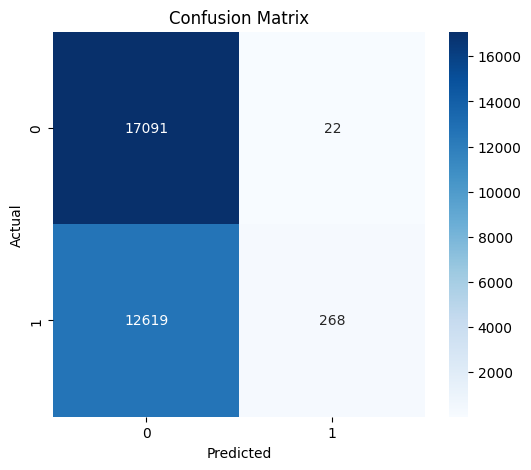

BATCH 48 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3739, Val Loss: 0.3370
Epoch 2/10, Train Loss: 0.3467, Val Loss: 0.3271
Epoch 3/10, Train Loss: 0.3281, Val Loss: 0.3130
Epoch 4/10, Train Loss: 0.3230, Val Loss: 0.3239
Epoch 5/10, Train Loss: 0.3263, Val Loss: 0.3005
Epoch 6/10, Train Loss: 0.3097, Val Loss: 0.2942
Epoch 7/10, Train Loss: 0.2943, Val Loss: 0.2867
Epoch 8/10, Train Loss: 0.2910, Val Loss: 0.2707
Epoch 9/10, Train Loss: 0.2801, Val Loss: 0.2666
Epoch 10/10, Train Loss: 0.2712, Val Loss: 0.2522
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5818
Confusion Matrix:
[[16980    56]
 [12491   473]]


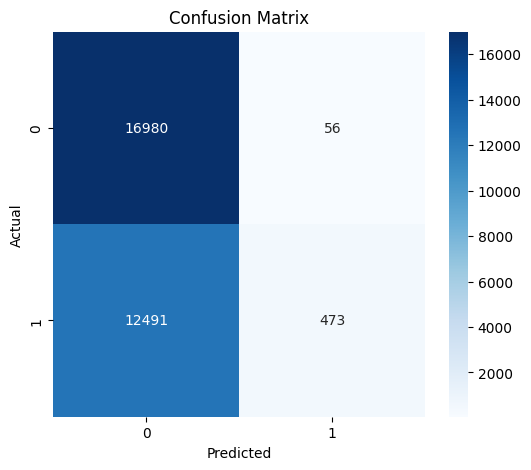

BATCH 49 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3933, Val Loss: 0.3669
Epoch 2/10, Train Loss: 0.3485, Val Loss: 0.3351
Epoch 3/10, Train Loss: 0.3324, Val Loss: 0.3175
Epoch 4/10, Train Loss: 0.3074, Val Loss: 0.2913
Epoch 5/10, Train Loss: 0.3054, Val Loss: 0.2872
Epoch 6/10, Train Loss: 0.2932, Val Loss: 0.2780
Epoch 7/10, Train Loss: 0.2857, Val Loss: 0.2833
Epoch 8/10, Train Loss: 0.2824, Val Loss: 0.2661
Epoch 9/10, Train Loss: 0.2695, Val Loss: 0.2626
Epoch 10/10, Train Loss: 0.2660, Val Loss: 0.2516
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5704
Confusion Matrix:
[[16873    68]
 [12819   240]]


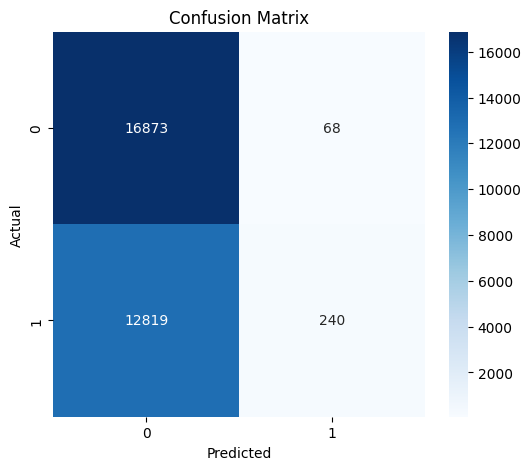

BATCH 50 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3648, Val Loss: 0.3222
Epoch 2/10, Train Loss: 0.3302, Val Loss: 0.3103
Epoch 3/10, Train Loss: 0.3152, Val Loss: 0.2979
Epoch 4/10, Train Loss: 0.2969, Val Loss: 0.2792
Epoch 5/10, Train Loss: 0.2843, Val Loss: 0.2706
Epoch 6/10, Train Loss: 0.2719, Val Loss: 0.2639
Epoch 7/10, Train Loss: 0.2661, Val Loss: 0.2490
Epoch 8/10, Train Loss: 0.2504, Val Loss: 0.2449
Epoch 9/10, Train Loss: 0.2428, Val Loss: 0.2330
Epoch 10/10, Train Loss: 0.2384, Val Loss: 0.2288
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5618
Confusion Matrix:
[[16571   178]
 [12968   283]]


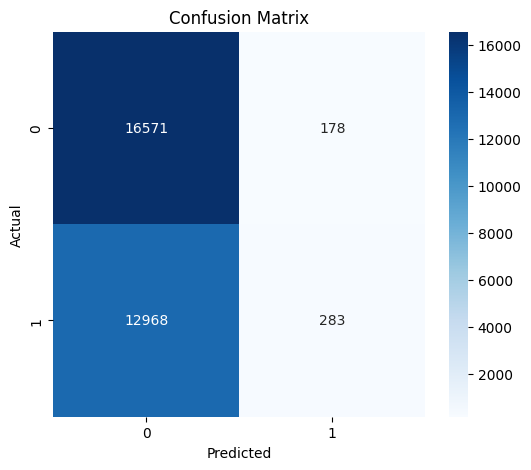

BATCH 51 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3880, Val Loss: 0.3497
Epoch 2/10, Train Loss: 0.3360, Val Loss: 0.3291
Epoch 3/10, Train Loss: 0.3343, Val Loss: 0.3106
Epoch 4/10, Train Loss: 0.3084, Val Loss: 0.2923
Epoch 5/10, Train Loss: 0.3032, Val Loss: 0.3022
Epoch 6/10, Train Loss: 0.2936, Val Loss: 0.2820
Epoch 7/10, Train Loss: 0.2882, Val Loss: 0.2695
Epoch 8/10, Train Loss: 0.2741, Val Loss: 0.2601
Epoch 9/10, Train Loss: 0.2744, Val Loss: 0.2547
Epoch 10/10, Train Loss: 0.2666, Val Loss: 0.2453
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5610
Confusion Matrix:
[[16448    69]
 [13102   381]]


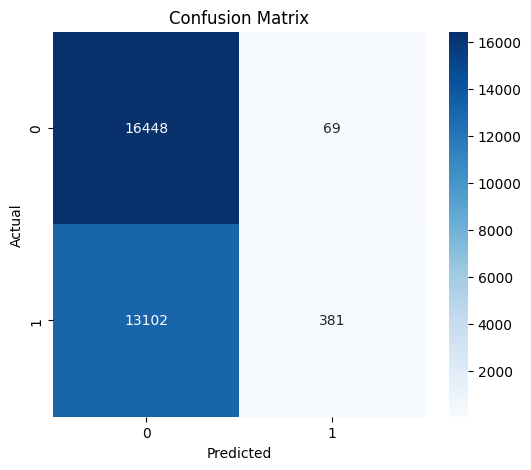

BATCH 52 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.3659, Val Loss: 0.3259
Epoch 2/10, Train Loss: 0.3125, Val Loss: 0.3096
Epoch 3/10, Train Loss: 0.3087, Val Loss: 0.2811
Epoch 4/10, Train Loss: 0.2995, Val Loss: 0.2797
Epoch 5/10, Train Loss: 0.2920, Val Loss: 0.2814
Epoch 6/10, Train Loss: 0.2896, Val Loss: 0.2634
Epoch 7/10, Train Loss: 0.2658, Val Loss: 0.2478
Epoch 8/10, Train Loss: 0.2584, Val Loss: 0.2462
Epoch 9/10, Train Loss: 0.2478, Val Loss: 0.2362
Epoch 10/10, Train Loss: 0.2496, Val Loss: 0.2293
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5961
Confusion Matrix:
[[17710   118]
 [12000   172]]


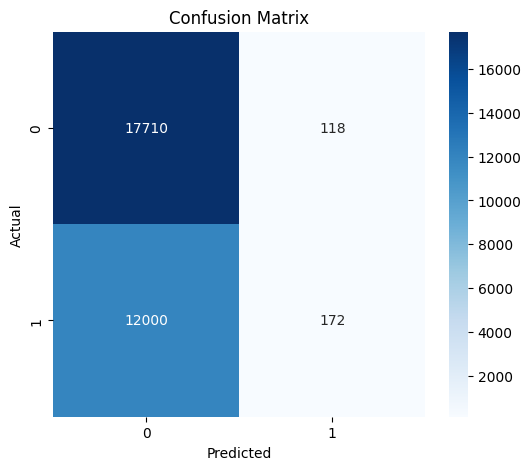

BATCH 53 out of TOTAL: 54 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/10, Train Loss: 0.4343, Val Loss: 0.3879
Epoch 2/10, Train Loss: 0.3820, Val Loss: 0.3507
Epoch 3/10, Train Loss: 0.3537, Val Loss: 0.3456
Epoch 4/10, Train Loss: 0.3417, Val Loss: 0.3223
Epoch 5/10, Train Loss: 0.3297, Val Loss: 0.3129
Epoch 6/10, Train Loss: 0.3164, Val Loss: 0.3040
Epoch 7/10, Train Loss: 0.3030, Val Loss: 0.2904
Epoch 8/10, Train Loss: 0.2946, Val Loss: 0.2743
Epoch 9/10, Train Loss: 0.2802, Val Loss: 0.2772
Epoch 10/10, Train Loss: 0.2924, Val Loss: 0.2935
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5630
Confusion Matrix:
[[16583    61]
 [13049   307]]


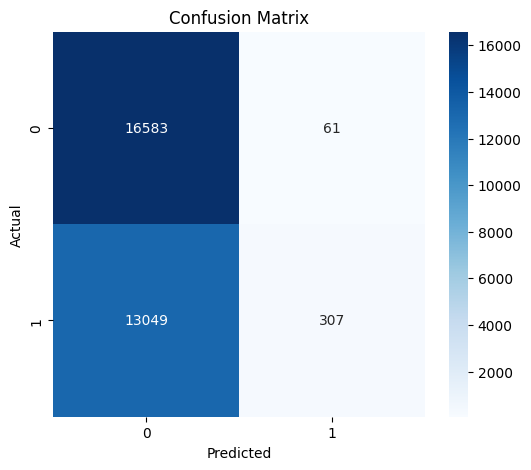

BATCH 54 out of TOTAL: 54 completed
Training Completed


In [15]:
import numpy as np
from vap_sound.config import MFCC_SAMPLE_RATE, FUTURE_OFFSET, HOP_LENGTH, N_MFCC_PER_FRAME, BATCH_SIZE, SEQ_LENGTH, LEARNING_RATE
from vap_sound.utils.extract_mfcc_torchaudio import MFCC_EXTRACTION

batch = 0
batch_file_size = 500
total = int(len(file_df)/batch_file_size)
model = VAPModel()
mfcc_extraction = MFCC_EXTRACTION()

for i in range(0, len(file_df)-batch_file_size, batch_file_size):
    # print(i)

    ## Training ##
    train_files = file_df['file_paths'][i: i+batch_file_size]
    # print(f"Training on {len(train_files)} files")
    # print(train_files)
    #  = extract_mfcc_features(train_files)
    training_data = mfcc_extraction.extract_mfcc_features(
        audio_files = train_files,
        target_sample_rate=MFCC_SAMPLE_RATE, 
        future_offset=FUTURE_OFFSET, 
        n_mfcc=N_MFCC_PER_FRAME, 
        hop_length=HOP_LENGTH  
    )
    train_model(training_data, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, seq_length=SEQ_LENGTH, learning_rate=LEARNING_RATE)

    # ## Evaluation
    random_integer = np.random.randint(1, len(file_df)- batch_file_size)
    eval_files = file_df['file_paths'][random_integer: random_integer + 300]
    eval_data = mfcc_extraction.extract_mfcc_features(
        audio_files=eval_files, 
        target_sample_rate=MFCC_SAMPLE_RATE, 
        future_offset=FUTURE_OFFSET, 
        n_mfcc=N_MFCC_PER_FRAME, 
        hop_length=HOP_LENGTH  
    )
    eval_dataset = VAPDataset(eval_data)
    eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=True)
    evaluate_model(model, eval_dataloader, output_file=LOG_MODEL_EVALUATION, metrics_file=LOG_MODEL_PREDICTION)

    batch += 1
    print(f"BATCH {batch} out of TOTAL: {total} completed")

print("Training Completed")